<h1>DeepFake Starter Kit</h1>



# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Preliminary data exploration</a>  
    * Load the packages  
    * Load the data  
    * Check files type  
- <a href='#3'>Meta data exploration</a>  
     * Missing data   
     * Unique values  
     * Most frequent originals  
- <a href='#4'>Video data exploration</a>  
     * Missing video (or meta) data  
     * Few fake videos  
     * Few real videos  
     * Videos with same original  
     * Test video files  
     * Play video files
- <a href='#5'>Face detection</a>  
- <a href='#6'>Resources</a> 
- <a href='#7'>References</a>     



# <a id='1'>Introduction</a>


DeepFake is composed from Deep Learning and Fake and means taking one person  from an image or video and replacing with someone else
likeness using technology such as Deep Artificial Neural Networks [1]. Large companies like Google invest very much in fighting the DeepFake, this including release of large datasets to help training models to counter this threat [2].The phenomen invades rapidly the film industry and threatens to compromise news agencies. Large digital companies, including content providers and social platforms are in the frontrun of fighting Deep Fakes. GANs that generate DeepFakes becomes better every day and, of course, if you include in a new GAN model all the information we collected until now how to combat various existent models, we create a model that cannot be beatten by the existing ones.   

In the **Data Exploration** section we perform a (partial) Exploratory Data Analysis (EDA) on the training and testing data. After we are checking the files types, we are focusing first on the **metadata** files, which we are exploring in details, after we are importing in dataframes. Then, we move to explore video files, by looking first to a sample of fake videos, then to real videos. After that, we are also exploring few of the videos with the same origin. We are visualizing one frame extracted from the video, for both real and fake videos. Then we are also playing few videos.  
Then, we move to perform face (and other `objects` from the persons in the videos) extraction. More precisely, we are using OpenCV Haar Cascade resources to identify frontal face, eyes, smile and profile face from still images in the videos.

**Important note**: The data we analyze here is just a very small sample of data. The competition specifies that the train data is provided as archived chunks. Training of models should pe performed offline using the data provided by Kaggle as archives, models should be loaded (max 1GB memory) in a Kernel, where inference should be performed (submission sample file provided) and prediction should be prepared as an output file from the Kernel.


In the **Resources** section I provide a short list of various resources for GAN and DeepFake, with blog posts, Kaggle Kernels and Github repos.   



# <a id='2'>Preliminary data exploration</a>

## Load packages

In [18]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv

## Load data

In [19]:
DATA_FOLDER = '/srv/hdd2/javber/dfdc/'
TRAIN_SAMPLE_FOLDER = 'dfdc_train_all'
TEST_FOLDER = 'deepfake-detection-challenge/test_videos'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

Train samples: 119148
Test samples: 400


We also added a face detection resource.

## Check files type

Here we check the train data files extensions. Most of the files looks to have `mp4` extension, let's check if there is other extension as well.

Let's count how many files with each extensions there are.

Let's repeat the same process for test videos folder.

In [20]:
train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

Extensions: ['mp4']
Files with extension `mp4`: 119146


Let's check the `json` file first.

In [21]:
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


Aparently here is a metadata file. Let's explore this JSON file.

In [22]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

label  split        original
owxbbpjpch.mp4  FAKE  train  wynotylpnm.mp4
vpmyeepbep.mp4  REAL  train             NaN
fzvpbrzssi.mp4  REAL  train             NaN
htorvhbcae.mp4  FAKE  train  wclvkepakb.mp4
fckxaqjbxk.mp4  FAKE  train  vpmyeepbep.mp4

# <a id="3">Meta data exploration</a>

Let's explore now the meta data in train sample. 

## Missing data

We start by checking for any missing values.  

In [23]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [24]:
missing_data(meta_train_df)

label   split   original
Total         0       0      19154
Percent     0.0     0.0  16.074995
Types    object  object     object

There are missing data 16.074% of the samples (or 77). We suspect that actually the real data has missing original (if we generalize from the data we glimpsed). Let's check this hypothesis.

In [25]:
missing_data(meta_train_df.loc[meta_train_df.label=='REAL'])

label   split original
Total         0       0    19154
Percent     0.0     0.0    100.0
Types    object  object   object

Indeed, all missing `original` data are the one associated with `REAL` label.  

## Unique values

Let's check into more details the unique values.

In [26]:
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

In [27]:
unique_values(meta_train_df)

label   split  original
Total    119154  119154    100000
Uniques       2       1     19154

* We observe that `original` label has the same pattern for uniques values. We know that we have 77 missing data (that's why total is only 323) and we observe that we do have 209 unique examples.  

## Most frequent originals

Let's look now to the most frequent originals uniques in train sample data.  

In [28]:
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequence'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

In [29]:
most_frequent_values(meta_train_df)

label   split        original
Total               119154  119154          100000
Most frequent item    FAKE   train  tfyyefqpfs.mp4
Frequence           100000  119154              40
Percent from total  83.925   100.0            0.04

We see that most frequent **label** is `FAKE` (80.75%), `meawmsgiti.mp4` is the most frequent **original** (6 samples).

Let's do now some data distribution visualizations.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_count(feature, title, df, size=1):
    '''
    Plotea un countplot para una columna específica de un DataFrame.
    
    Parámetros:
    - feature: nombre de la columna para analizar (string).
    - title: título que se agregará al gráfico (string).
    - df: DataFrame que contiene la columna a analizar.
    - size: tamaño de la figura (float), por defecto es 1.
    '''
    # Verificar si la columna existe en el DataFrame
    if feature not in df.columns:
        raise ValueError(f"La columna '{feature}' no existe en el DataFrame.")
    
    # Crear la figura y el eje
    f, ax = plt.subplots(1, 1, figsize=(4*size, 4))
    total = float(len(df))
    
    # Crear el countplot
    g = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index, palette='Set3', ax=ax)
    
    # Agregar el título al gráfico
    g.set_title("Number and percentage of {}".format(title))
    
    # Rotar las etiquetas del eje x si el tamaño es mayor que 2
    if size > 2:
        plt.xticks(rotation=90, size=8)
    
    # Agregar las etiquetas de porcentaje a las barras
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}%'.format(100 * height / total),
                ha="center") 
    
    # Mostrar el gráfico
    plt.show()


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_count(feature, title, df, size=1, output_path='/home/javber/repositorio/deep_fake_detection/extras/dfdc/output.png'):
    '''
    Plotea un countplot para una columna específica de un DataFrame y guarda la gráfica como imagen.
    
    Parámetros:
    - feature: nombre de la columna para analizar (string).
    - title: título que se agregará al gráfico (string).
    - df: DataFrame que contiene la columna a analizar.
    - size: tamaño de la figura (float), por defecto es 1.
    - output_path: ruta completa y nombre del archivo donde se guardará la imagen (string).
                   Si no se proporciona, la imagen no se guarda.
    '''
    # Verificar si la columna existe en el DataFrame
    if feature not in df.columns:
        raise ValueError(f"La columna '{feature}' no existe en el DataFrame.")
    
    # Crear la figura y el eje
    f, ax = plt.subplots(1, 1, figsize=(4*size, 4))
    total = float(len(df))
    
    # Crear el countplot
    g = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index, palette='Set3', ax=ax)
    
    # Agregar el título al gráfico
    g.set_title("Numero y porcentaje de {}".format(title))
    
    # Rotar las etiquetas del eje x si el tamaño es mayor que 2
    if size > 2:
        plt.xticks(rotation=90, size=8)
    
    # Agregar las etiquetas de porcentaje a las barras
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.2f}%'.format(100 * height / total),
                ha="center") 
    
    # Guardar el gráfico si se proporciona la ruta de salida
    if output_path:
        plt.savefig(output_path, format='png', dpi=300)

    # Mostrar el gráfico
    plt.show()



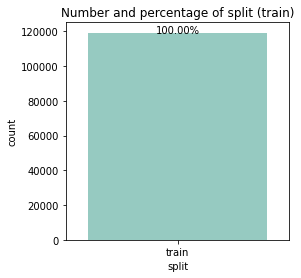

In [62]:
plot_count('split', 'split (train)', meta_train_df)

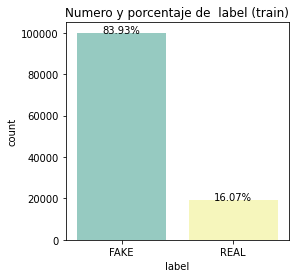

In [69]:
plot_count('label', 'label (train)', meta_train_df)

As we can see, the `REAL` are only 19.25% in train sample videos, with the `FAKE`s acounting for 80.75% of the samples. 


# <a id="4">Video data exploration</a>


In the following we will explore some of the video data. 


## Missing video (or meta) data

We check first if the list of files in the meta info and the list from the folder are the same.



In [34]:
meta = np.array(list(meta_train_df.index))
storage = np.array([file for file in train_list if  file.endswith('mp4')])
print(f"Metadata: {meta.shape[0]}, Folder: {storage.shape[0]}")
print(f"Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique=False).shape[0]}")
print(f"Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique=False).shape[0]}")

Metadata: 119154, Folder: 119146
Files in metadata and not in folder: 8
Files in folder and not in metadata: 0


Let's visualize now the data.  

We select first a list of fake videos.

## Few fake videos

In [35]:
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='FAKE'].sample(3).index)
fake_train_sample_video

['ngulptlssh.mp4', 'jovqqmdngq.mp4', 'ggnyicrmrd.mp4']

From [4] ([Basic EDA Face Detection, split video, ROI](https://www.kaggle.com/marcovasquez/basic-eda-face-detection-split-video-roi)) we modified a function for displaying a selected image from a video.

In [36]:
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)

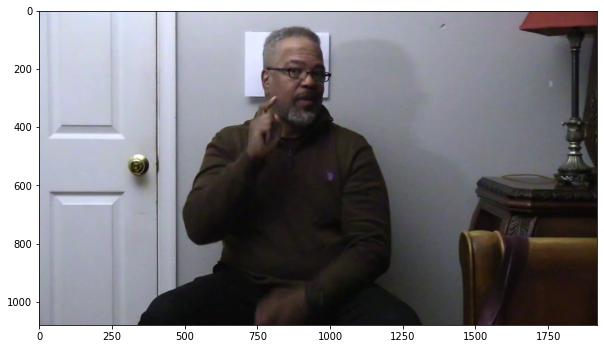

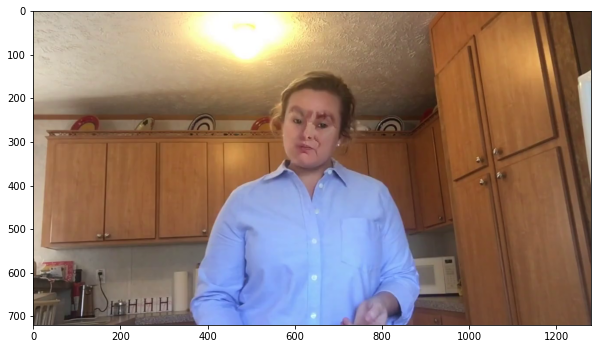

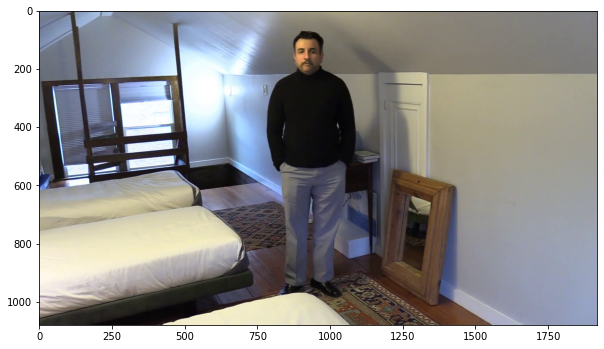

In [37]:
for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

Let's try now the same for few of the images that are real.  


## Few real videos

In [38]:
real_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='REAL'].sample(3).index)
real_train_sample_video

['qijtymyvog.mp4', 'jrlncrfwcj.mp4', 'dosvmrkqws.mp4']

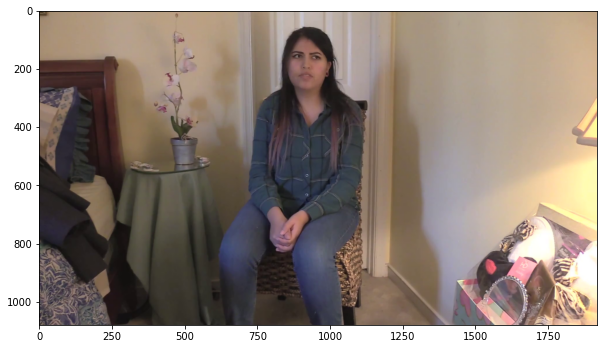

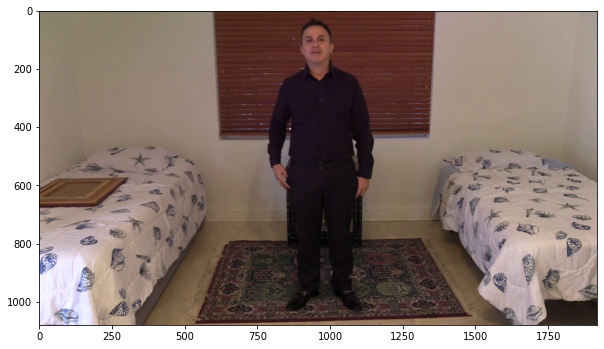

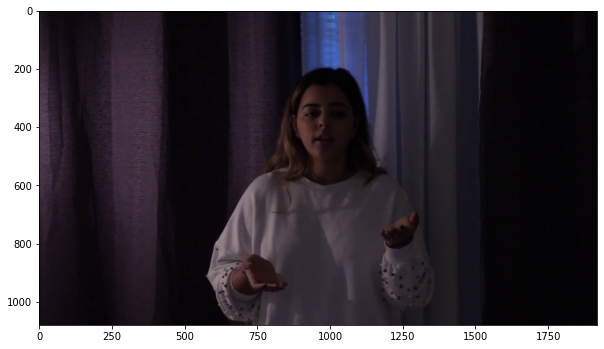

In [39]:
for video_file in real_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

## Videos with same original

Let's look now to set of samples with the same original.

In [40]:
meta_train_df['original'].value_counts()[0:5]

tfyyefqpfs.mp4    40
zgdtjzfrad.mp4    39
rqsotnryhj.mp4    39
ypgayhhaxx.mp4    39
ivctdtckcn.mp4    38
Name: original, dtype: int64

We pick one of the originals with largest number of samples.   

We also modify our visualization function to work with multiple images.

In [41]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')

<Figure size 432x288 with 0 Axes>

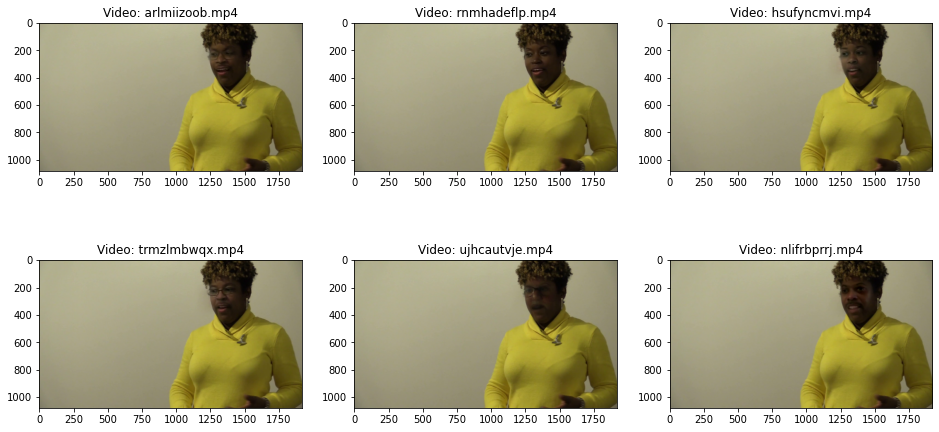

In [42]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='meawmsgiti.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

Let's look now to a different selection of videos with the same original. 

<Figure size 432x288 with 0 Axes>

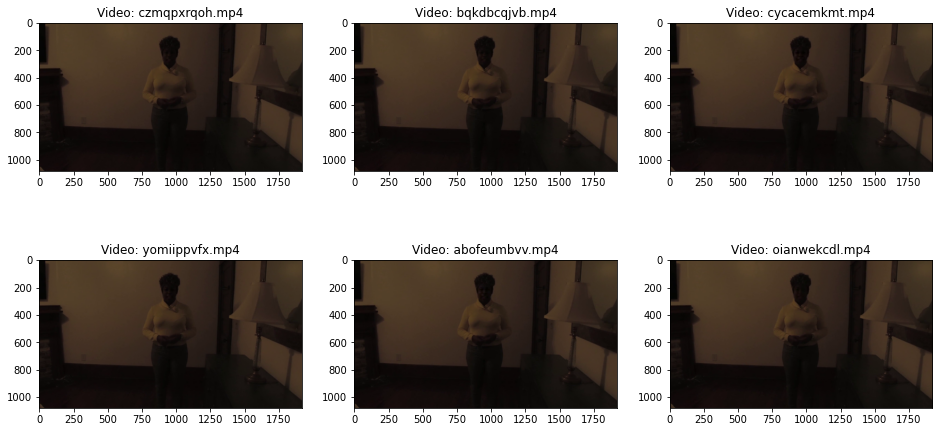

In [43]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='atvmxvwyns.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

<Figure size 432x288 with 0 Axes>

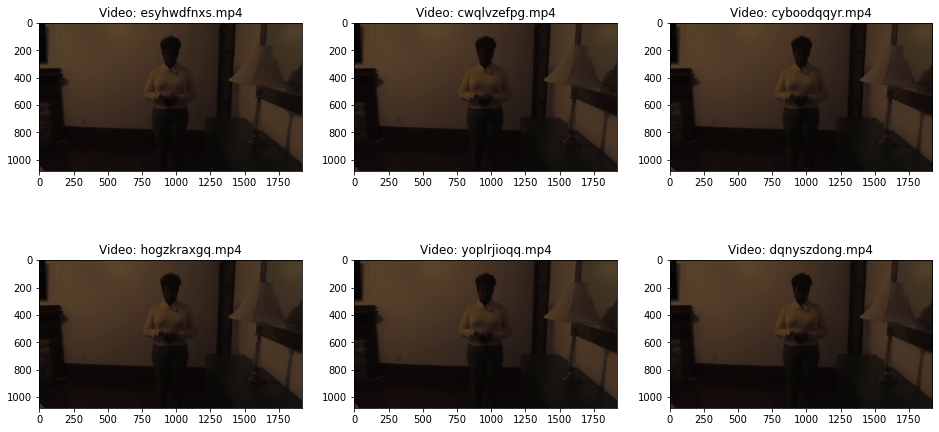

In [44]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='qeumxirsme.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

<Figure size 432x288 with 0 Axes>

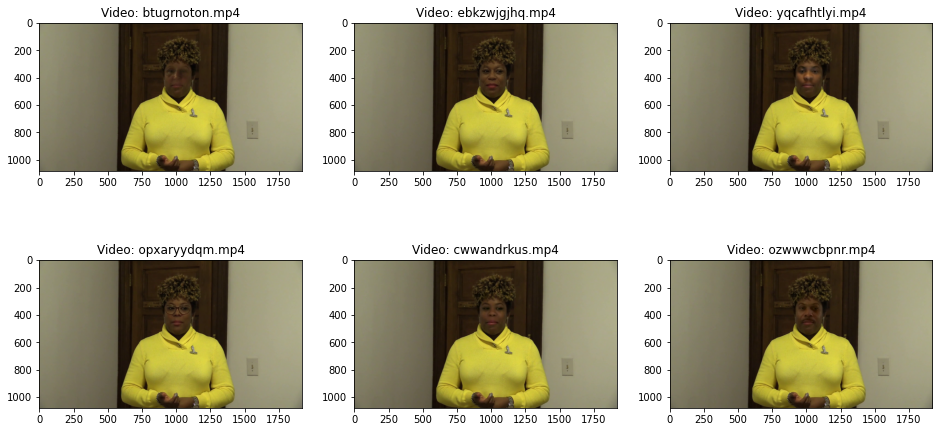

In [45]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='kgbkktcjxf.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

## Test video files

Let's also look to few of the test data files.

In [46]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])

In [47]:
test_videos.head()

video
0  swsaoktwgi.mp4
1  evysmtpnrf.mp4
2  vssmlqoiti.mp4
3  oefukgnvel.mp4
4  vhbbwdflyh.mp4

Let's visualize now one of the videos.

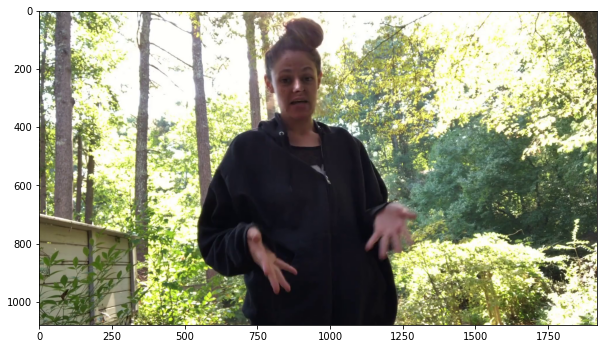

In [48]:
display_image_from_video(os.path.join(DATA_FOLDER, TEST_FOLDER, test_videos.iloc[0].video))

Let's look to some more videos from test set.

<Figure size 432x288 with 0 Axes>

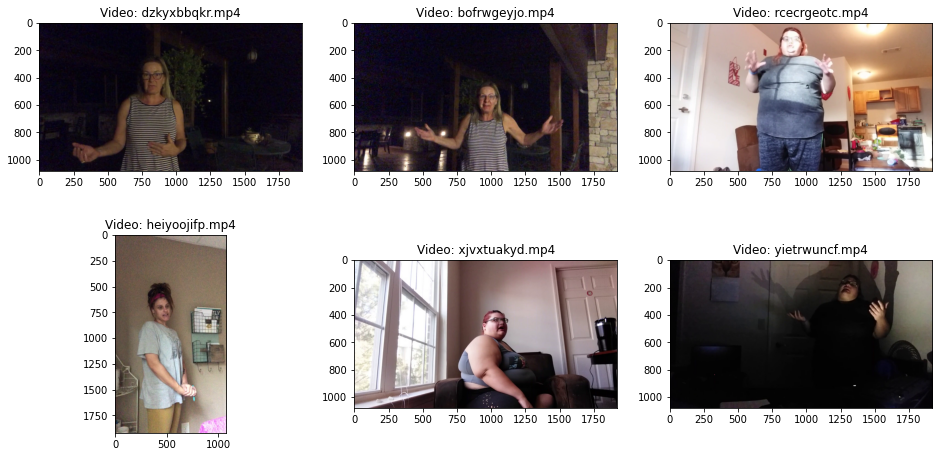

In [49]:
display_image_from_video_list(test_videos.sample(6).video, TEST_FOLDER)

# <a id='5'>Face detection</a>  

From [5] ([Face Detection using OpenCV](https://www.kaggle.com/serkanpeldek/face-detection-with-opencv)) by [@serkanpeldek](https://www.kaggle.com/serkanpeldek) we got and slightly modified the functions to extract face, profile face, eyes and smile.  

The class ObjectDetector initialize the cascade classifier (using the imported resource). The function **detect** uses a method of the CascadeClassifier to detect objects into images - in this case the face, eye, smile or profile face.

In [50]:
class ObjectDetector():
    '''
    Class for Object Detection
    '''
    def __init__(self,object_cascade_path):
        '''
        param: object_cascade_path - path for the *.xml defining the parameters for {face, eye, smile, profile}
        detection algorithm
        source of the haarcascade resource is: https://github.com/opencv/opencv/tree/master/data/haarcascades
        '''

        self.objectCascade=cv.CascadeClassifier(object_cascade_path)


    def detect(self, image, scale_factor=1.3,
               min_neighbors=5,
               min_size=(20,20)):
        '''
        Function return rectangle coordinates of object for given image
        param: image - image to process
        param: scale_factor - scale factor used for object detection
        param: min_neighbors - minimum number of parameters considered during object detection
        param: min_size - minimum size of bounding box for object detected
        '''
        rects=self.objectCascade.detectMultiScale(image,
                                                scaleFactor=scale_factor,
                                                minNeighbors=min_neighbors,
                                                minSize=min_size)
        return rects

We load the resources for frontal face, eye, smile and profile face detection.  

Then we initialize the `ObjectDetector` objects defined above with the respective resources, to use CascadeClassfier for each specific task.

In [51]:
#Frontal face, profile, eye and smile  haar cascade loaded
frontal_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_frontalface_default.xml')
eye_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_eye.xml')
profile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_profileface.xml')
smile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_smile.xml')

#Detector object created
# frontal face
fd=ObjectDetector(frontal_cascade_path)
# eye
ed=ObjectDetector(eye_cascade_path)
# profile face
pd=ObjectDetector(profile_cascade_path)
# smile
sd=ObjectDetector(smile_cascade_path)

NameError: name 'FACE_DETECTION_FOLDER' is not defined

We also define a function for detection and display of all these specific objects.  

The function call the **detect** method of the **ObjectDetector** object. For each object we are using a different shape and color, as following:
* Frontal face: green rectangle;  
* Eye: red circle;  
* Smile: red rectangle;  
* Profile face: blue rectangle.  

Note: due to a huge amount of false positive, we deactivate for now the smile detector.

In [ ]:
def detect_objects(image, scale_factor, min_neighbors, min_size):
    '''
    Objects detection function
    Identify frontal face, eyes, smile and profile face and display the detected objects over the image
    param: image - the image extracted from the video
    param: scale_factor - scale factor parameter for `detect` function of ObjectDetector object
    param: min_neighbors - min neighbors parameter for `detect` function of ObjectDetector object
    param: min_size - minimum size parameter for f`detect` function of ObjectDetector object
    '''
    
    image_gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)


    eyes=ed.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    for x, y, w, h in eyes:
        #detected eyes shown in color image
        cv.circle(image,(int(x+w/2),int(y+h/2)),(int((w + h)/4)),(0, 0,255),3)
 
    # deactivated due to many false positive
    #smiles=sd.detect(image_gray,
    #               scale_factor=scale_factor,
    #               min_neighbors=min_neighbors,
    #               min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    #for x, y, w, h in smiles:
    #    #detected smiles shown in color image
    #    cv.rectangle(image,(x,y),(x+w, y+h),(0, 0,255),3)


    profiles=pd.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    for x, y, w, h in profiles:
        #detected profiles shown in color image
        cv.rectangle(image,(x,y),(x+w, y+h),(255, 0,0),3)

    faces=fd.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    for x, y, w, h in faces:
        #detected faces shown in color image
        cv.rectangle(image,(x,y),(x+w, y+h),(0, 255,0),3)

    # image
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ax.imshow(image)

The following function extracts an image from a video and then call the function that extracts the face rectangle from the image and display the rectangle above the image.

In [ ]:
def extract_image_objects(video_file, video_set_folder=TRAIN_SAMPLE_FOLDER):
    '''
    Extract one image from the video and then perform face/eyes/smile/profile detection on the image
    param: video_file - the video from which to extract the image from which we extract the face
    '''
    video_path = os.path.join(DATA_FOLDER, video_set_folder,video_file)
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    detect_objects(image=frame, 
            scale_factor=1.3, 
            min_neighbors=5, 
            min_size=(50, 50))  
  

We apply the function for face detection for a selection of images from train sample videos.

In [ ]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='kgbkktcjxf.mp4'].index)
for video_file in same_original_fake_train_sample_video[1:4]:
    print(video_file)
    extract_image_objects(video_file)

In [ ]:
train_subsample_video = list(meta_train_df.sample(3).index)
for video_file in train_subsample_video:
    print(video_file)
    extract_image_objects(video_file)

Let's look to a small collection of samples from test videos.

In [ ]:
subsample_test_videos = list(test_videos.sample(3).video)
for video_file in subsample_test_videos:
    print(video_file)
    extract_image_objects(video_file, TEST_FOLDER)

We can observe that in some cases, when the subject is not looking frontaly or when the luminosity is low, the algorithm for face detection is not detecting the face or eyes correctly. Due to a large amount of false positive, we deactivated for now the smile detector.

## Play video files  

From [Play video and processing](https://www.kaggle.com/hamditarek/play-video-and-processing) Kernel by [@hamditarek](https://www.kaggle.com/hamditarek) we learned how to play video files in a Kaggle Kernel.  
Let's look to few fake videos.

In [ ]:
fake_videos = list(meta_train_df.loc[meta_train_df.label=='FAKE'].index)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_FOLDER, subset,video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

In [ ]:
play_video(fake_videos[0])

In [ ]:
play_video(fake_videos[1])

In [ ]:
play_video(fake_videos[2])

In [ ]:
play_video(fake_videos[3])

In [ ]:
play_video(fake_videos[4])

In [ ]:
play_video(fake_videos[5])

In [ ]:
play_video(fake_videos[10])

In [ ]:
play_video(fake_videos[12])

In [ ]:
play_video(fake_videos[15])

In [ ]:
play_video(fake_videos[18])

From visual inspection of these fakes videos, in some cases is very easy to spot the anomalies created when engineering the deep fake, in some cases is more difficult.

# <a id="6">Resources</a>  

This resources list is not exhaustive, it provides just a starting point for Kagglers that would like to join this competition in order to learn, like myself.    

I provide here technical articles links, small blog articles, links to Github projects and some inspirational Kaggle Kernels about DeepFake, DCGANs and GANs.   

**Blogs, Technical Articles**

* Towards Data Science DeepFakes subject selection: [DeepFakes](https://towardsdatascience.com/tagged/deepfakes)   

* An introduction to DeepFakes from Towards Data Science: [Deepfakes: The Ugly, and The Good](https://towardsdatascience.com/deepfakes-the-ugly-and-the-good-49115643d8dd)  

* Introduction to GAN from Towards Data Science (with code): [GANs from Scratch 1: A deep introduction. With code in PyTorch and TensorFlow](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f)  

* A cGAN introduction from Mastering Data Science (with code): [How to Develop a Conditional GAN (cGAN) From Scratch](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/)   

* An introduction to GANs on Analytics Vidhya,  [GANs — A Brief Introduction to Generative Adversarial Networks](https://medium.com/analytics-vidhya/gans-a-brief-introduction-to-generative-adversarial-networks-f06216c7200e?)

**Tutorials**

* A nice tutorial for GAN using Pytorch: [DCGAN Faces Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)  

* A tutorial for GANs: [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://pathmind.com/wiki/generative-adversarial-network-gan)  

* Deep Convolutional Generative Adversial Networks, Tensorflow, [DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan)    

* A tutorial for video and image colorization and resolution improvement using fast.ai and PyTorch recommended by [@init27](https://www.kaggle.com/init27), [Decrappification, DeOldification, and Super Resolution](https://www.fast.ai/2019/05/03/decrappify/)  

* A tutorial from OpenCV for face detection using Cascade Classifiers, [Cascade Classifier](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)  

**Kaggle Kernels**

* A very good intro to GAN, by [@nanashi](http://kaggle/nanashi): [GAN Introduction](https://www.kaggle.com/jesucristo/gan-introduction)    

* A GAN developed for Dog face generation competition by [@cdeotte](http://kaggle/cdeotte): [Dog Memorizer GAN](https://www.kaggle.com/cdeotte/dog-memorizer-gan)    

* A Kernel for Face detection using OpenCV with Haarcascade, by [@serkanpeldek](https://www.kaggle.com/serkanpeldek), [Face Detection with OpenCV](https://www.kaggle.com/serkanpeldek/face-detection-with-opencv)   

* Play video and processing, by [@hamditarek](https://www.kaggle.com/hamditarek),  https://www.kaggle.com/hamditarek/play-video-and-processing   


**Github repos**

* Github topic for DeeFakes: [deepfakes](https://github.com/topics/)  

* A Github project using Pytorch: [Faceswap-Deepfake-Pytorch](https://github.com/Oldpan/Faceswap-Deepfake-Pytorch)   

* A Github project for GAN with PyTorch: [PyTorch-GAN](https://github.com/eriklindernoren/PyTorch-GAN)  

* A Github recommended by [@shwetagoyal4](https://www.kaggle.com/shwetagoyal4), [Generative-model-using-PyTorch](https://github.com/Shwetago/Generative-model-using-PyTorch)

# <a id="7">References</a>

[1] Deepfake, Wikipedia, https://en.wikipedia.org/wiki/Deepfake  
[2] Google DeepFake Database, Endgadget, https://www.engadget.com/2019/09/25/google-deepfake-database/  
[3] A quick look at the first frame of each video,  https://www.kaggle.com/brassmonkey381/a-quick-look-at-the-first-frame-of-each-video  
[4] Basic EDA Face Detection, split video, ROI, https://www.kaggle.com/marcovasquez/basic-eda-face-detection-split-video-roi  
[5] Face Detection with OpenCV, https://www.kaggle.com/serkanpeldek/face-detection-with-opencv   
[6] Play video and processing, https://www.kaggle.com/hamditarek/play-video-and-processing/
